### Loading needed libraries and reading datasets. We later save them in a .py file which is used in other notebooks/scripts as a local library.

##### We are reading and analysing the refenrece Vortex time serie and observations.
We are:
1. Comparing measurements and time serie in concurrent period. This shows any outliers in the measurements thorugh XY graphs but also histograms or wind rose.
2. estimating accuracy of reference time serie versus measurements
3. Compare histogram and wind rose deviations of measurement period versus climatology. This is done consistently using and comparing both periods of the same reference time serie.
4. finally we are using the time serie from vortex to analyse daily patterns, yearly patterns and different shear analysis.

In [1]:
#libraries
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

### measurements
data/measurements/fino2.102.01.txt<br />
<b>Format:</b><br />
YYYYmmdd HHMM WSSPD Dir STD<br />
20150101 0000 12.8 100 0.67<br />
20150101 0010 13.2 100 0.89<br />
20150101 0020 14.3 100 0.92<br />
20150101 0030 14.7 100 0.88<br />

In [2]:
def readMeasurements(file):
    data=pd.read_csv(file,sep=" ",header=None)
    data.columns=['date','time','wspd_obs','hgt_obs','std_obs']
    data['time']=data['time'].astype(str).str.zfill(4)
    data['datetime']=pd.to_datetime(data['date'].astype(str)+ ' ' +data['time'].astype(str),format='%Y%m%d %H%M')
    data=data.drop(['date','time'],axis=1)
    data=data.set_index('datetime')

    return data
obs=readMeasurements("data/measurements/fino2.102.01.txt")
obs.describe()

,wspd_obs,hgt_obs,std_obs
count,51417.000000,51417.0,51417.000000
mean,9.780298,100.0,0.673561
std,4.661955,0.0,0.437476
min,0.300000,100.0,0.030000
25%,6.100000,100.0,0.350000
50%,9.300000,100.0,0.560000
75%,13.100000,100.0,0.900000
max,30.500000,100.0,5.420000


## Vortex txt serie, downloaded from interface

<b> Format:</b><br />
Lat=55.00701  Lon=13.15399  Hub-Height=100  Timezone=0   ASL-Height(avg. 3km-grid)=0  (file requested on 2022-03-18 09:32:17)
VORTEX (www.vortex.es) - Computed at 3km resolution based on ERA5 data (designed for correlation purposes)<br />
 
YYYYMMDD HHMM  M(m/s) D(deg)  T(C)  De(k/m3) PRE(hPa)      RiNumber  RH(%)   RMOL(1/m)<br />
20000101 0000    7.7    240    2.1    1.28    1010.0          -1.04   92.6     -0.0163<br />
20000101 0100    7.5    232    1.9    1.28    1009.9          -1.54   93.9     -0.0178<br />
20000101 0200    7.6    224    1.7    1.28    1009.9          -1.71   94.9     -0.0189<br />


In [3]:
def readVortex(file):
    data=pd.read_table(file,skiprows=3,sep=" ",skipinitialspace=True)
    data['HHMM']=['{i:04}'.format(i=i, width=4) for i in data['HHMM']]
    data['datetime']=pd.to_datetime(data['YYYYMMDD'].astype(str)+ ' ' +data['HHMM'].astype(str),format='%Y%m%d %H%M')
    data=data.drop(['YYYYMMDD','HHMM'],axis=1)
    data=data.set_index('datetime')
    data=data.rename(columns={'M(m/s)':'wspd_serie100','D(deg)':'wdir_serie100'})
    return data
vortexSerie100=readVortex("data/vortex/SERIE/vortex.serie.100m.era5.txt")[['wspd_serie100','wdir_serie100']]
vortexSerie100.describe()


,wspd_serie100,wdir_serie100
count,182568.000000,182568.000000
mean,9.742155,202.548628
std,4.425139,89.182528
min,0.000000,0.000000
25%,6.500000,127.000000
50%,9.600000,226.000000
75%,12.700000,272.000000
max,31.300000,360.000000


In [4]:
def readSerie(file):
    netcdf_file=file
    site = xr.open_dataset(netcdf_file)
    site['wspd_serie']=(site['U']**2+site['V']**2)**(1/2)
    site['wdir_serie']=np.arctan2(site['U'],site['V'])*180/math.pi + 180
    return site
file="data/vortex/SERIE/serie.d02.nc"
vortexSerie=readSerie(file)[['wspd_serie','wdir_serie']].interp(lev=100).to_dataframe().reset_index().drop(['lat','lon','lev'],axis=1).set_index('time')
vortexSerie.describe()

,wspd_serie,wdir_serie
count,182568.000000,182568.000000
mean,9.744928,202.517324
std,4.423886,88.724239
min,0.036954,0.077362
25%,6.498877,127.155813
50%,9.572988,225.743298
75%,12.706730,271.849825
max,31.254156,359.949365


### Having date time as index we can now concatenate and compare consistently for concurrent period

In [5]:
## Concatenate concurrent period
tmp=obs.merge(vortexSerie100,left_index=True,right_index=True)
merged=tmp.merge(vortexSerie,left_index=True,right_index=True)
merged.describe()

,wspd_obs,hgt_obs,std_obs,wspd_serie100,wdir_serie100,wspd_serie,wdir_serie
count,8568.000000,8568.0,8568.000000,8568.000000,8568.000000,8568.000000,8568.000000
mean,9.790394,100.0,0.674056,10.494596,213.856326,10.497281,213.861515
std,4.674751,0.0,0.439800,4.582545,80.671412,4.580872,80.098114
min,0.300000,100.0,0.030000,0.200000,0.000000,0.222976,0.542678
25%,6.100000,100.0,0.350000,7.000000,155.000000,7.043023,155.049839
50%,9.300000,100.0,0.570000,10.300000,236.000000,10.268454,235.357980
75%,13.100000,100.0,0.900000,13.700000,273.000000,13.660559,273.115304
max,29.500000,100.0,4.280000,26.900000,360.000000,26.931013,359.559799


Some graphics are usefull for both check reference time serie accuracy but also check for suspicious outliers in observations data

## Comparing in concurrent period

### Histogram

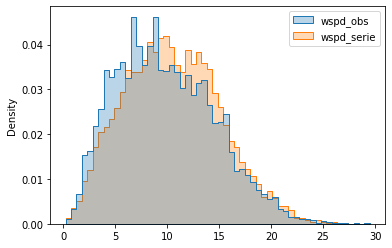

In [6]:
sns.histplot(data=merged[['wspd_obs','wspd_serie']],alpha=0.3,element="step", stat='density')
plt.show()

### XY plot / correlation
We can check here the agreement in the time dimension but also any outlier we should check in the measurements. This way, the reference time serie serves as consistency check.

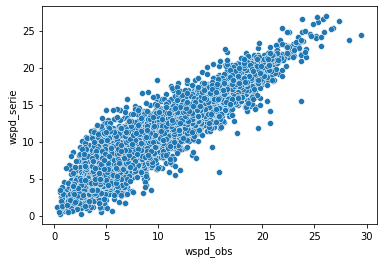

In [7]:
sns.scatterplot(data=merged,x='wspd_obs',y='wspd_serie')
plt.show()

### Comparing wind roses in concurrent period
same for wind rose as seen in histogram. We are checking accuracy of reference time serie in the wind direction but also any major deviance or anomaly in the wind direction field.

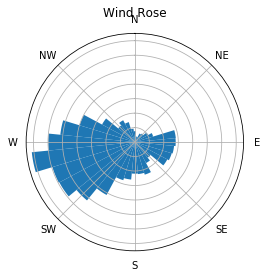

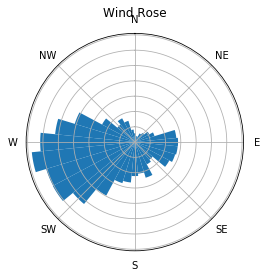

In [8]:

def windRose(tmpdata,col,sectors : int =16) -> None:
    df=tmpdata.to_frame()
    values=df[col]
    n_sectors = sectors
    width_sectors = 360.0/n_sectors+0.00000001
    sectors = np.arange(0.0, 360.0, width_sectors)
    width_bins = width_sectors/2
    bins = np.arange(0, 360 + width_bins/2, width_bins)[0:-1]
    df['sec']=np.vectorize(math.floor)(values/width_sectors)
    num = df.groupby('sec')[col].count().values
    number_events=num
    ax = plt.axes(projection='polar')
    ax.bar(np.radians(sectors), number_events, width=np.radians(width_sectors))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax.set_yticklabels('')
    ax.set_title('Wind Rose. \n')
    plt.title('Wind Rose')
    plt.show()
    
windRose(merged['wdir_serie100'],'wdir_serie100',32)
windRose(merged['wdir_serie'],'wdir_serie',32)


### We are now going to validate the reference time serie with typical metrics

In [9]:
def validate(obs,data):
    colnames=['obs.mean (m/s)','mean (m/s)','bias %','ME %','MAE %','R2','RMSE %']
    obs=obs
    data=data
    meanobs=obs.mean()
    meandata=data.mean()
    ME=100*(data-obs).mean()/obs.mean()
    bias=100*(data.mean()-obs.mean())/obs.mean()
    MAE=100*abs(obs-data).mean()/obs.mean()
    R2=np.corrcoef(np.squeeze(data),np.squeeze(obs))[0,1]
    RMSE=100*((((data-obs) ** 2).mean()) ** .5)/obs.mean()
    result=[[meanobs,meandata,bias,ME,MAE,R2,RMSE]]
    df = pd.DataFrame(data=result, columns=colnames)
    return(df)

df=validate(merged['wspd_obs'],merged['wspd_serie'])
print(df)
## in a more fancy way we can display data in a more readable and cool way
from IPython.display import display, HTML
display(df)
df=validate(merged['wspd_obs'],merged['wspd_serie100'])
display(df)

   obs.mean (m/s)  mean (m/s)    bias %      ME %      MAE %        R2  \
0        9.790394   10.497281  7.220202  7.220202  14.113718  0.929094   

      RMSE %  
0  19.231173  


,obs.mean (m/s),mean (m/s),bias %,ME %,MAE %,R2,RMSE %
0,9.790394,10.497281,7.220202,7.220202,14.113718,0.929094,19.231173


,obs.mean (m/s),mean (m/s),bias %,ME %,MAE %,R2,RMSE %
0,9.790394,10.494596,7.192781,7.192781,14.108037,0.929048,19.2284


## Comparing different periods using reference Vortex serie.
We are now using the reference serie to see how the observations period compares to the long term period.
We see that when using shorter periods may disagree with long term.

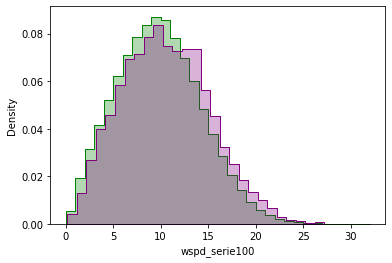

In [10]:
sns.histplot(data=vortexSerie100['wspd_serie100'],alpha=0.3,element="step", stat='density',binwidth=1,color="green")
sns.histplot(data=merged['wspd_serie100'],alpha=0.3,element="step", stat='density',binwidth=1,color="purple")
plt.show()

Obs concurrent period


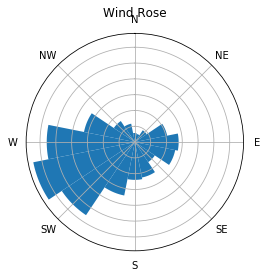

LT period


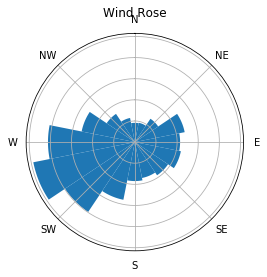

In [11]:
print("Obs concurrent period")
windRose(merged['wdir_serie100'],'wdir_serie100')
print("LT period")
windRose(vortexSerie100['wdir_serie100'],'wdir_serie100')

## Loading NetCDF using xarray libraries
we are going to load easily _NetCDF_ files into xarray objects. Xarray is a powerfull tool which may compare to _Climate Data Operators_ (CDO) and _NCO_ when working with meteorological datasets in python directly instead of NetCDF and command line.
### manipulate and create some auxiliary columns

In [23]:
def np_rep(x, reps=1, each=False, length=0):
    if length > 0:
        reps = np.int(np.ceil(length / x.size))
    x = np.repeat(x, reps)
    if(not each):
        x = x.reshape(-1, reps).T.ravel()
    if length > 0:
        x = x[0:length]
    return(x)

xr_mast=readSerie(file)[['wspd_serie','wdir_serie']]
#just move into pandas in one line:
df = xr_mast.to_dataframe()

nlev=df.index.get_level_values('lev').nunique()
years = xr_mast.coords['time'].dt.year.values
months = xr_mast.coords['time'].dt.month.values
days = xr_mast.coords['time'].dt.day.values
hours = xr_mast.coords['time'].dt.hour.values

repyears=np_rep(years,reps=nlev,each=False)
repmonths=np_rep(months,reps=nlev,each=False)
repdays=np_rep(days,reps=nlev,each=False)
repyears=np_rep(years,reps=nlev,each=False)
repmonths=np_rep(months,reps=nlev,each=False)
rephours=np_rep(hours,reps=nlev,each=False)
print(xr_mast)

<xarray.Dataset>
Dimensions:     (time: 182568, lev: 10, lat: 1, lon: 1)
Coordinates:
  * lon         (lon) float32 13.15
  * lat         (lat) float32 55.01
  * lev         (lev) float32 8.0 28.0 52.0 80.0 ... 182.0 220.0 263.0 330.0
  * time        (time) datetime64[ns] 2000-01-01 ... 2020-10-28T23:00:00
Data variables:
    wspd_serie  (time, lev, lat, lon) float32 6.773 7.288 7.491 ... 14.07 14.94
    wdir_serie  (time, lev, lat, lon) float32 239.6 239.5 239.6 ... 213.8 218.6
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.0
    history:      Wed Mar 23 11:06:02 2022: cdo merge foo.nc new2.nc kk.nc\nW...
    CDO:          Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/...


### tab file 24 x 12

###############  24 x 12   ###############


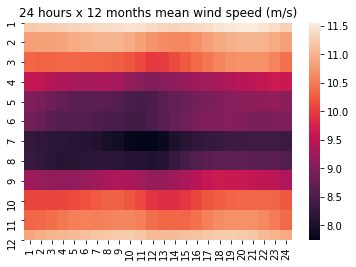

In [22]:
print("###############  24 x 12   ###############")
colors = sns.color_palette('husl', 30)
levs=df.index.get_level_values('lev').unique()
xr_M=xr_mast['wspd_serie'].squeeze(drop=True)
sheardata=[]
for month in range(1,13):
    row=xr_M.interp(lev=100).where((xr_M.time.dt.month == month)).groupby('time.hour').mean(skipna=True).values
    sheardata.append(row)

dfplot=pd.DataFrame(data=sheardata,columns=range(1,25),index=range(1,13))
#display(dfplot)
sns.heatmap(data=dfplot)
plt.title("24 hours x 12 months mean wind speed (m/s)")
plt.show()


### Anual variation

monthly variation


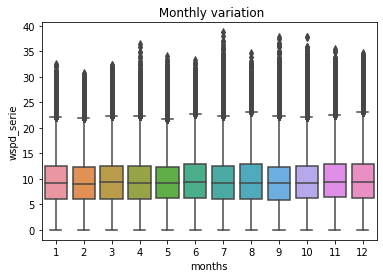

In [13]:
print("monthly variation")

df['months'] = repmonths
#ax = plt.axes()
#sns.violinplot(x='months', y='wspd_serie', data=df, ax=ax)
#sns.pointplot(x='months', y='wspd_serie', data=df, ax=ax)
sns.boxplot(x='months', y='wspd_serie', data=df)
plt.title(' Monthly variation')
plt.show()

### Daily profile

hourly variation


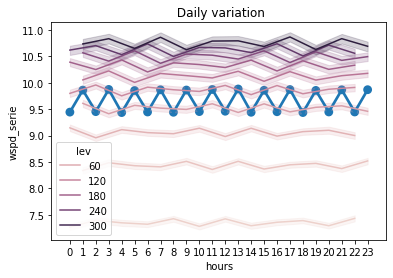

In [14]:
print("hourly variation")
df['hours'] = rephours
ax = plt.axes()
#sns.violinplot(x='hours', y='wspd_serie', data=df, ax=ax)
sns.pointplot(x='hours', y='wspd_serie', data=df, ax=ax)
sns.lineplot(x='hours',y='wspd_serie',data=df,hue='lev',ax=ax)
plt.title(' Daily variation')
plt.show()

### Shear 

###############  SHEAR by hours  ###############


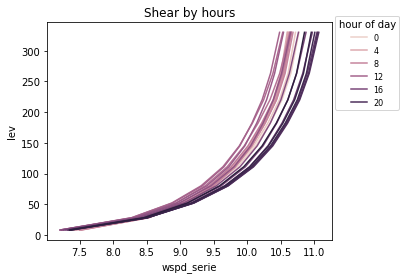

In [15]:
print("###############  SHEAR by hours  ###############")
colors = sns.color_palette('husl', 30)
levs=df.index.get_level_values('lev').unique()
xr_M=xr_mast['wspd_serie'].squeeze(drop=True)
sheardata=xr_M.groupby('time.hour').mean(skipna=True).to_dataframe()
#display(sheardata)
sns.lineplot(data=sheardata,y='lev',x='wspd_serie',hue='hour')
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width*0.85, box.height])
plt.legend(bbox_to_anchor=(1.25, 1.05), ncol=1, fontsize=8,title='hour of day')
plt.title("Shear by hours")
plt.show()


###############  SHEAR by months  ###############


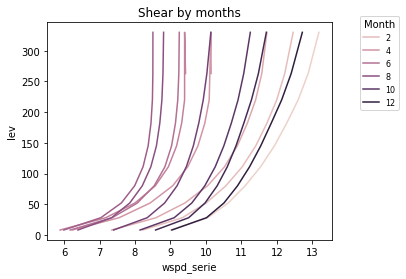

In [16]:
print("###############  SHEAR by months  ###############")
colors = sns.color_palette('husl', 30)
levs=df.index.get_level_values('lev').unique()
xr_M=xr_mast['wspd_serie'].squeeze(drop=True)
sheardata=xr_M.groupby('time.month').mean(skipna=True).to_dataframe()
#display(sheardata)
sns.lineplot(data=sheardata,y='lev',x='wspd_serie',hue='month')
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width*0.85, box.height])
plt.legend(bbox_to_anchor=(1.25, 1.05), ncol=1, fontsize=8,title='Month')
plt.title("Shear by months")
plt.show()

###############  SHEAR by wind speed bins  ###############


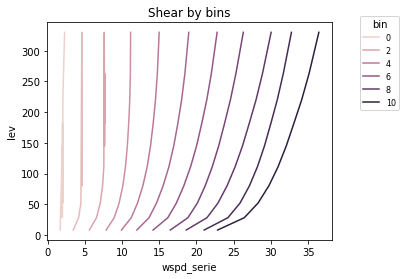

In [21]:
print("###############  SHEAR by wind speed bins  ###############")
colors = sns.color_palette('husl', 30)
levs=df.index.get_level_values('lev').unique()
xr_M=xr_mast['wspd_serie'].squeeze(drop=True).to_dataset()
## set bin wind wpeed classification equal for all levels based on level 4
xr_M['bin']=(xr_M.isel(lev=4)['wspd_serie']/3).astype('int')
dfplot=xr_M.to_dataframe()
dfplot=dfplot.reset_index().set_index(['bin','time','lev'])
sheardata=dfplot.reset_index().set_index('time').groupby(['bin','lev']).mean()
#display(sheardata)
sns.lineplot(data=sheardata,y='lev',x='wspd_serie',hue='bin')
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width*0.85, box.height])
plt.legend(bbox_to_anchor=(1.25, 1.05), ncol=1, fontsize=8,title='bin')
plt.title("Shear by bins")
plt.show()